**DATA EXTRACTION**

In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Load the Excel file
file_name = list(uploaded.keys())[0]
excel_data = pd.ExcelFile(file_name)

# Display available sheets
print("Available sheets:", excel_data.sheet_names)

# Load the first sheet and preview data
df = excel_data.parse(excel_data.sheet_names[0])
df.head()


Saving Healthcare Data.xlsx to Healthcare Data.xlsx
Available sheets: ['Fact PatientTreatment', 'DimTreatment', 'DimPatient', 'DimHospital', 'DimHealthIndicator', 'DimDoctor', 'DimDate']


,fact_id,treatment_key,patient_key,doctor_key,hospital_key,date_key,indicator_key,billing_amount,treatment_cost,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,length_of_stay
0,1,1,1,1,1,1,1,42072.66,3941.97,10,4154.39,3083.12,349.72,5
1,2,2,2,2,2,2,2,2830.16,4158.44,17,1606.70,789.80,1703.89,6
2,3,3,3,3,3,3,3,11455.22,3731.55,61,2246.89,2611.03,519.08,3
3,4,4,4,4,4,4,4,10515.09,4799.86,88,1993.96,1358.72,869.70,8
4,5,5,5,5,5,5,5,17177.98,582.05,56,3975.79,1862.53,1563.96,1


**LIBRARIES**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error
import tensorflow as tf
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

**CLUSTERING (K-MEANS)**

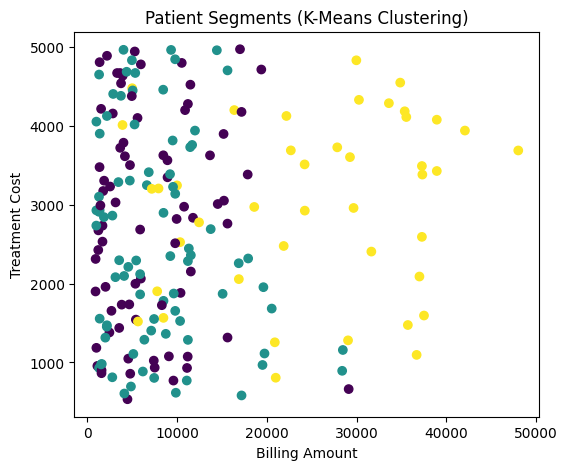


🧩 CLUSTERING RESULTS:
         billing_amount  treatment_cost  length_of_stay  \
Cluster                                                   
0               6982.19         2821.43            5.37   
1               7907.56         2551.20            3.28   
2              25271.09         3038.64            6.48   

         average_total_payments  average_medicare_payments  
Cluster                                                     
0                       1296.85                    1157.90  
1                       3121.25                    1213.16  
2                       2813.30                     983.21  


In [6]:
# 🧩 1. CLUSTERING (K-MEANS)
# -----------------------------------------------------------
# PURPOSE:
# To group patients into meaningful segments based on
# demographics, costs, and treatment patterns.
# Example: "High-spending older patients" vs "Young healthy patients"
# ===========================================================

# Selecting numeric features for clustering
num_features = ['billing_amount', 'treatment_cost', 'length_of_stay',
                'average_total_payments', 'average_medicare_payments']

data = df[num_features].dropna()

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Applying K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizing clusters
plt.figure(figsize=(6,5))
plt.scatter(data['billing_amount'], data['treatment_cost'], c=df['Cluster'], cmap='viridis')
plt.title("Patient Segments (K-Means Clustering)")
plt.xlabel("Billing Amount")
plt.ylabel("Treatment Cost")
plt.show()

# Cluster insights
print("\n🧩 CLUSTERING RESULTS:")
print(df.groupby('Cluster')[num_features].mean().round(2))

**ANOMALY DETECTION (ISOLATION FOREST)**

In [8]:
# 🚨 3. ANOMALY DETECTION (ISOLATION FOREST)
# -----------------------------------------------------------
# PURPOSE:
# To detect unusual patient billing patterns or potential
# fraud cases where cost behavior deviates strongly from normal.
# ===========================================================

iso = IsolationForest(contamination=0.02, random_state=42)
df['AnomalyFlag'] = iso.fit_predict(X_scaled)

# -1 → Anomaly, 1 → Normal
anomalies = df[df['AnomalyFlag'] == -1]
print("\n🚨 ANOMALY DETECTION RESULTS:")
print("Total anomalies detected:", anomalies.shape[0])
print("Sample anomalies:\n", anomalies[num_features + ['billing_amount']].head())



🚨 ANOMALY DETECTION RESULTS:
Total anomalies detected: 4
Sample anomalies:
      billing_amount  treatment_cost  length_of_stay  average_total_payments  \
9          37511.41         1595.67               9                 2482.42   
140        48017.12         3689.35               6                 1725.44   
141        29118.06          662.72               2                  702.45   
175        36690.56         1096.36               8                 2891.41   

     average_medicare_payments  billing_amount  
9                       310.86        37511.41  
140                    1501.01        48017.12  
141                     353.70        29118.06  
175                    1957.15        36690.56  


**GENERATIVE AI**

In [10]:
# 🧬 5. GENERATIVE AI
# -----------------------------------------------------------
# PURPOSE:
# To generate synthetic healthcare records for experimentation
# without exposing real patient data (privacy-preserving).
# ===========================================================

# Select numeric columns for GAN
gan_data = df[num_features].dropna()
scaler_gan = MinMaxScaler(feature_range=(-1, 1))
X_gan = scaler_gan.fit_transform(gan_data.values)

latent_dim = 32
n_features = X_gan.shape[1]

# --- Generator ---
def make_generator():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_features, activation='tanh')
    ])
    return model

# --- Discriminator ---
def make_discriminator():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=n_features),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

generator = make_generator()
discriminator = make_discriminator()

# Combined GAN model
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
generated = generator(gan_input)
validity = discriminator(generated)
combined = models.Model(gan_input, validity)
combined.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy')

# Training (small-scale)
epochs = 500
batch_size = 64
half_batch = batch_size // 2

for epoch in range(epochs):
    idx = np.random.randint(0, X_gan.shape[0], half_batch)
    real = X_gan[idx]
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake = generator.predict(noise, verbose=0)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake, np.zeros((half_batch, 1)))

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D_real={d_loss_real[0]:.3f}, D_fake={d_loss_fake[0]:.3f}, G={g_loss:.3f}")

# Generate synthetic data
noise = np.random.normal(0, 1, (10, latent_dim))
generated_data = generator.predict(noise)
synthetic = scaler_gan.inverse_transform(generated_data)
synthetic_df = pd.DataFrame(synthetic, columns=num_features)
print("\n🧬 SYNTHETIC DATA (sample):")
print(synthetic_df.head())

Epoch 0: D_real=0.574, D_fake=0.672, G=0.625
Epoch 100: D_real=0.705, D_fake=0.706, G=0.571
Epoch 200: D_real=0.728, D_fake=0.729, G=0.539
Epoch 300: D_real=0.741, D_fake=0.742, G=0.521
Epoch 400: D_real=0.748, D_fake=0.749, G=0.511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

🧬 SYNTHETIC DATA (sample):
   billing_amount  treatment_cost  length_of_stay  average_total_payments  \
0    47942.046875     4970.240723        8.685179             3985.834717   
1    47999.816406     4954.071289        8.873936             3988.585449   
2    47979.863281     4973.080078        8.943884             3984.540527   
3    47908.816406     4963.593750        8.934953             3983.798828   
4    48008.613281     4971.843262        8.899170             3991.857910   

   average_medicare_payments  
0                 357.761200  
1                 430.661163  
2                 331.318146  
3                 429.882843  
4                 367.700867  


**ML APPLICATION**

Data loaded successfully!
Merged data shape: (200, 28)

🔧 Creating better features...
Using IMPROVED features: ['age', 'bmi', 'length_of_stay', 'total_discharges', 'average_covered_charges', 'average_total_payments', 'average_medicare_payments', 'billing_amount', 'cost_to_billing_ratio', 'payment_coverage_ratio', 'medicare_ratio', 'age_bmi_interaction', 'treatment_type_encoded', 'condition_encoded']
X shape: (200, 14), y shape: (200,)
Target stats - Mean: $2756.25, Std: $1298.13
Train set: 160, Test set: 40

🔄 Training improved models...

📊 IMPROVED Model Performance:

Random Forest:
  Train R²: 0.9631
  Test R²:  0.8502
  RMSE:     $529.28
  MAPE:     16.90%
  CV R²:    0.7828 ± 0.1356

Linear Regression:
  Train R²: 0.6645
  Test R²:  0.6975
  RMSE:     $752.10
  MAPE:     38.40%
  CV R²:    0.5422 ± 0.0743

FINAL RESULTS
🏆 BEST MODEL: Random Forest
   Test R²: 0.8502
   RMSE: $529.28
   MAPE: 16.90%

🔍 MODEL HEALTH CHECK:
  Random Forest: ⚠️  OVERFITTING (gap: 0.113)
  Linear Regres

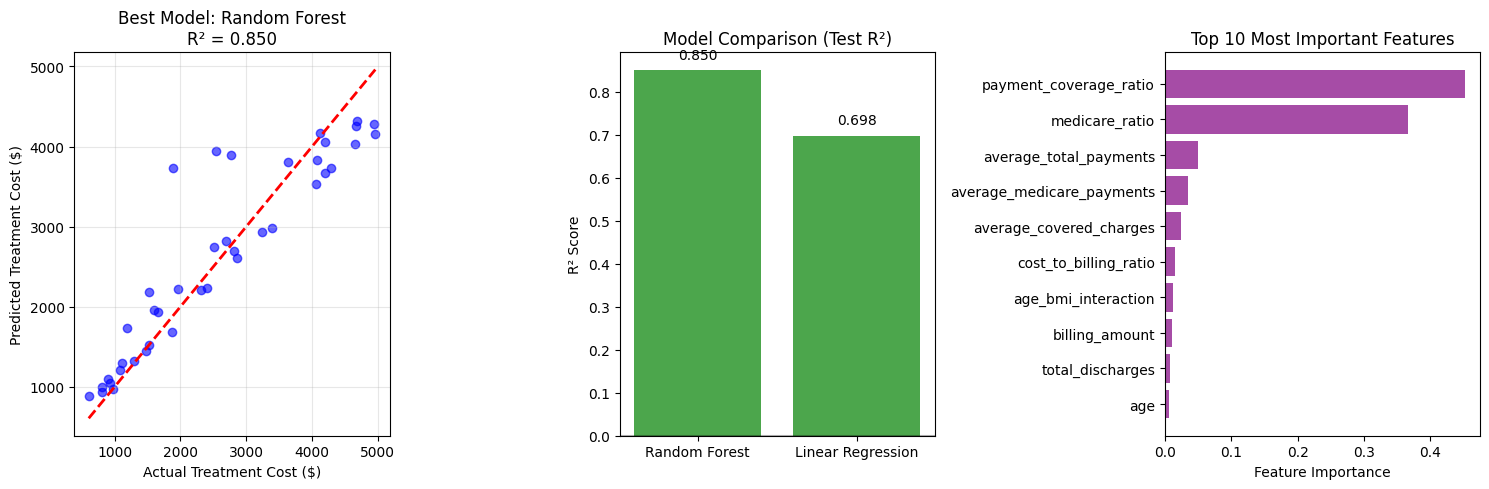


💡 RECOMMENDATIONS:
1. ✅ Model can be used for cost estimation
2. 💰 Helps in budget planning and resource allocation
3. 📈 Identifies key cost drivers in healthcare services


In [7]:

# Load your data
file_name = list(uploaded.keys())[0]
excel_data = pd.ExcelFile(file_name)

fact_df = pd.read_excel(excel_data, sheet_name='Fact PatientTreatment')
treatment_df = pd.read_excel(excel_data, sheet_name='DimTreatment')
patient_df = pd.read_excel(excel_data, sheet_name='DimPatient')

print("Data loaded successfully!")

# Merge data
df = fact_df.merge(treatment_df, on='treatment_key').merge(patient_df, on='patient_key')
print(f"Merged data shape: {df.shape}")

# BETTER FEATURE ENGINEERING
print("\n🔧 Creating better features...")

# 1. Create meaningful ratios and interactions
df['cost_to_billing_ratio'] = df['treatment_cost'] / df['billing_amount']
df['payment_coverage_ratio'] = df['average_total_payments'] / df['treatment_cost']
df['medicare_ratio'] = df['average_medicare_payments'] / df['treatment_cost']
df['age_bmi_interaction'] = df['age'] * df['bmi']

# 2. Use treatment type as simple categories (convert to numbers safely)
treatment_mapping = {'Chemotherapy': 0, 'MRI': 1, 'ECG': 2, 'Physiotherapy': 3, 'X-Ray': 4}
df['treatment_type_encoded'] = df['treatment_type'].map(treatment_mapping).fillna(0)

# 3. Use medical condition as categories
condition_mapping = {'Cancer': 0, 'Obesity': 1, 'Diabetes': 2, 'Asthma': 3, 'Hypertension': 4, 'Arthritis': 5}
df['condition_encoded'] = df['medical_condition'].map(condition_mapping).fillna(0)

# 4. Select BETTER features
features = [
    'age', 'bmi', 'length_of_stay', 'total_discharges',
    'average_covered_charges', 'average_total_payments',
    'average_medicare_payments', 'billing_amount',
    'cost_to_billing_ratio', 'payment_coverage_ratio',
    'medicare_ratio', 'age_bmi_interaction',
    'treatment_type_encoded', 'condition_encoded'
]

# Use only features that exist
available_features = [f for f in features if f in df.columns]
print(f"Using IMPROVED features: {available_features}")

# Prepare data
X = df[available_features].fillna(df[available_features].median())
y = df['treatment_cost']

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Target stats - Mean: ${y.mean():.2f}, Std: ${y.std():.2f}")

# Scale the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=available_features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")

# Train BETTER models with optimized parameters
print("\n🔄 Training improved models...")

# Model 1: Random Forest with regularization
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=8,  # Limit depth to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Model 2: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate models
models = {
    'Random Forest': rf_model,
    'Linear Regression': lr_model
}

results = {}

print("\n📊 IMPROVED Model Performance:")
print("=" * 60)

for name, model in models.items():
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    results[name] = {
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'RMSE': rmse,
        'MAPE': mape,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std()
    }

    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  RMSE:     ${rmse:.2f}")
    print(f"  MAPE:     {mape:.2f}%")
    print(f"  CV R²:    {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Find best model
best_model_name = max(results.items(), key=lambda x: x[1]['Test_R2'])[0]
best_model = models[best_model_name]

print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['Test_R2']:.4f}")
print(f"   RMSE: ${results[best_model_name]['RMSE']:.2f}")
print(f"   MAPE: {results[best_model_name]['MAPE']:.2f}%")

# Check for overfitting/underfitting
print("\n🔍 MODEL HEALTH CHECK:")
for name, result in results.items():
    gap = result['Train_R2'] - result['Test_R2']
    if gap > 0.15:
        status = "❌ SEVERE OVERFITTING"
    elif gap > 0.1:
        status = "⚠️  OVERFITTING"
    elif result['Test_R2'] < 0.3:
        status = "⚠️  UNDERFITTING"
    elif result['Test_R2'] < 0.5:
        status = "⚠️  MODERATE FIT"
    else:
        status = "✅ GOOD FIT"
    print(f"  {name}: {status} (gap: {gap:.3f})")

# Performance interpretation
print("\n🎯 PERFORMANCE INTERPRETATION:")
test_r2 = results[best_model_name]['Test_R2']
if test_r2 > 0.7:
    print("✅ EXCELLENT: Highly reliable for business decisions")
elif test_r2 > 0.5:
    print("✅ GOOD: Suitable for planning and estimation")
elif test_r2 > 0.3:
    print("⚠️  FAIR: Use with caution for rough estimates")
elif test_r2 > 0:
    print("❌ POOR: Not reliable for decision making")
else:
    print("❌ VERY POOR: Worse than simple average prediction")

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted for best model
plt.subplot(1, 3, 1)
y_pred_best = best_model.predict(X_test)
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Treatment Cost ($)')
plt.ylabel('Predicted Treatment Cost ($)')
plt.title(f'Best Model: {best_model_name}\nR² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)

# Plot 2: R² comparison
plt.subplot(1, 3, 2)
model_names = list(results.keys())
test_scores = [results[name]['Test_R2'] for name in model_names]
colors = ['green' if score > 0 else 'red' for score in test_scores]
bars = plt.bar(model_names, test_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Model Comparison (Test R²)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.3f}', ha='center', va='bottom')

# Plot 3: Feature importance
plt.subplot(1, 3, 3)
if best_model_name == 'Random Forest':
    feature_importance = best_model.feature_importances_
else:
    # For linear regression, use absolute coefficients as importance
    feature_importance = np.abs(best_model.coef_)

indices = np.argsort(feature_importance)[-10:]  # Top 10 features
plt.barh(range(len(indices)), feature_importance[indices], color='purple', alpha=0.7)
plt.yticks(range(len(indices)), [available_features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')

plt.tight_layout()
plt.show()

print("\n💡 RECOMMENDATIONS:")
if test_r2 <= 0:
    print("1. 🔄 Try collecting more data samples")
    print("2. 🎯 Focus on domain-specific feature engineering")
    print("3. 📊 Consider using simpler models or business rules")
    print("4. 🔍 Analyze if there's a logical relationship between features and cost")
else:
    print("1. ✅ Model can be used for cost estimation")
    print("2. 💰 Helps in budget planning and resource allocation")
    print("3. 📈 Identifies key cost drivers in healthcare services")